# Исследование данных о продажах компьютерных игр

В нашем распоряжении исторические данные из открытых источников - о продажах игр, оценках пользователей и экспертов, жанрах и платформах (например, Xbox или PlayStation). Задача - выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Перед нами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и мы планируеем кампанию на 2017-й. Отработаем принцип работы с данными.

**Описание данных:**

- Name — название игры;
- Platform — платформа;
- Year_of_Release — год выпуска;
- Genre — жанр игры;
- NA_sales — продажи в Северной Америке (миллионы проданных копий;
- EU_sales — продажи в Европе (миллионы проданных копий);
- JP_sales — продажи в Японии (миллионы проданных копий);
- Other_sales — продажи в других странах (миллионы проданных копий);
- Critic_Score — оценка критиков (максимум 100);
- User_Score — оценка пользователей (максимум 10);
- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board).

### Получение данных.

Откроем файл с данными и изучим общую информацию.

In [1]:
# импорт библиотек

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

In [2]:
# чтение файла с данными с сохранением в data
data = pd.read_csv('datasets/games.csv')
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [3]:
# получение общей информации о данных в таблице data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


**Рассмотрим полученную информацию подробнее.**

Всего в таблице 11 столбцов, тип данных - object и float64.

Количество значений в столбцах различается. Это говорит о том, что в данных есть пропущенные значения.

**Выводы:**

Каждая строка таблицы содержит информацию о продажах компьютерных игр с определенными параметрами данных. В данных имеются пропуски, для корректного анализа нужно их заменить или оставить пустыми, в зависимости от их ценности. Также нужно привести наименования столбцов к общему виду и заменить тип данных в некоторых столбцах.

### Предобработка данных.

Заменим наименования столбцов, исключим пропуски, преобразуем тип данных в выбранных столбцах, а также проверим данные на наличие дубликатов. Посчитаем суммарные продажи во всех регионах и запишем их в отдельный столбец.

In [4]:
# приведем наименование столбцов к нижнему регистру
data.columns = data.columns.str.lower()
data.columns.tolist()

['name',
 'platform',
 'year_of_release',
 'genre',
 'na_sales',
 'eu_sales',
 'jp_sales',
 'other_sales',
 'critic_score',
 'user_score',
 'rating']

In [5]:
# определим, в каких столбцах есть пропуски
data.isna().sum().sort_values()

platform              0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
name                  2
genre                 2
year_of_release     269
user_score         6701
rating             6766
critic_score       8578
dtype: int64

In [6]:
# посмотрим пропуски в процентах
data.isnull().sum().sort_values()/data.shape[0]*100

platform            0.000000
na_sales            0.000000
eu_sales            0.000000
jp_sales            0.000000
other_sales         0.000000
name                0.011965
genre               0.011965
year_of_release     1.609333
user_score         40.089740
rating             40.478612
critic_score       51.319174
dtype: float64

Пустые значения свидетельствуют, что в некоторых столбцах указана не вся информация. Критичное количество пропусков в столбцах с оценками и рейтингом. 

In [7]:
# посмотрим уникальные значения столбца rating
data['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

In [8]:
# заменим пропуски столбца rating на unknown, чтобы в дальнейшем была возможность оценить долю игр с отсутствующим рейтингом
data['rating'] = data['rating'].fillna('unknown')

In [9]:
# заменим рейтинг K-A на Е, т.к. с 1998 г. была смена наименования
# проверим успешно ли прошла замена
data['rating'] = data['rating'].replace('K-A', 'E')
data['rating'].unique()

array(['E', 'unknown', 'M', 'T', 'E10+', 'AO', 'EC', 'RP'], dtype=object)

In [10]:
# выведем уникальные значения столбца user_score
data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

In [11]:
# переименуем неизвестное значение в оценке'tbd' на NaN
# переведем тип данных на float для удобства расчета
data['user_score'] = data['user_score'].replace('tbd', np.NaN)
data['user_score'] = data['user_score'].astype('float')

In [12]:
# переведем тип данных на Int64 для удобства расчета
data['year_of_release'] = data['year_of_release'].astype('Int64')

In [13]:
# проверим 
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  Int64  
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           16715 non-null  object 
dtypes: Int64(1), float64(6), object(4)
memory usage: 1.4+ MB


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,unknown
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,unknown


In [14]:
data[data['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,NaN,NaN,unknown
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,NaN,NaN,unknown


In [15]:
# удалим пропуски в столбце name
data.dropna(subset = ['name'], inplace=True)

In [16]:
# проверим, удалились ли пропуски в столбце name
data.isna().sum()

name                  0
platform              0
year_of_release     269
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8576
user_score         9123
rating                0
dtype: int64

In [17]:
# проверим наличие явных дубликатов
data.duplicated().sum()

0

In [18]:
# заменим пропуски в столбцах с оценками на -1, т.к. замена на среднее- приведет к искажению результатов
# удаление строк тоже не возможно, т.к. будет потеряно 40-51% данных - это критично
data['user_score'] = data['user_score'].fillna(-1)
data['critic_score'] = data['critic_score'].fillna(-1)

In [19]:
# проверим наличие пропусков в процентах
data.isnull().sum().sort_values()/data.shape[0]*100

name               0.000000
platform           0.000000
genre              0.000000
na_sales           0.000000
eu_sales           0.000000
jp_sales           0.000000
other_sales        0.000000
critic_score       0.000000
user_score         0.000000
rating             0.000000
year_of_release    1.609526
dtype: float64

In [20]:
# посчитаем суммарные продажи и запишем в отдельных столбец
data['total_sales'] = data.na_sales + data.eu_sales + data.jp_sales + data.other_sales

In [21]:
 data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-1.0,-1.0,unknown,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,-1.0,-1.0,unknown,31.38


**Выводы:**

Привели наименования столбцов к нижнему регистру. В столбце rating слили 2 значения в одно, так как было переименование самого рейтинга, старые данные остались по предыдущему названию. Заменили пропуски в столбцах critic_score и user_score на -1, так как если совсем отбросить эти значения - критично, приведет к искажению результатов. Заменили тип данных для удобства расчетов в столбцах year_of_release на Int64, user_score на float. Заменили значение tbd в столбце user_score на NaN. 

###  Исследовательский анализ данных.

#### Рассмотрим сколько игр выпускалось в разные годы.

''

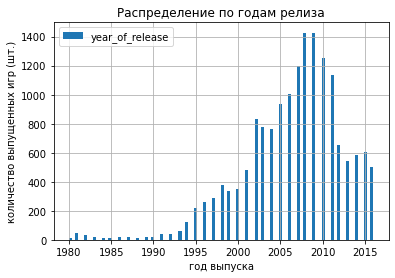

In [22]:
# построим гистограмму по годам выпуска игр
data['year_of_release'].plot(kind='hist', bins=100, range=(1980, 2016), grid=True).legend()
plt.title('Распределение по годам релиза')
plt.xlabel('год выпуска')
plt.ylabel('количество выпущенных игр (шт.)')
;

In [23]:
data.describe()

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,total_sales
count,16444.000000,16713.000000,16713.000000,16713.000000,16713.000000,16713.000000,16713.000000,16713.000000
mean,2006.486256,0.263302,0.145045,0.077625,0.047343,33.064920,2.689888,0.533315
std,5.875525,0.813565,0.503359,0.308871,0.186742,36.299815,4.169887,1.548282
min,1980.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.060000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,-1.000000,-1.000000,0.170000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,70.000000,7.300000,0.470000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000,9.700000,82.540000


Количество выпускаемых игр выросло приблизительно в 1998-2000ых годах. Пик выпуска игр пришлось на 2007-2009гг. С 2012 года наблюдается спад.

#### Рассмотрим, как менялись продажи по платформам.  За какой характерный срок появляются новые и исчезают старые платформы.

In [24]:
data.columns.tolist()

['name',
 'platform',
 'year_of_release',
 'genre',
 'na_sales',
 'eu_sales',
 'jp_sales',
 'other_sales',
 'critic_score',
 'user_score',
 'rating',
 'total_sales']

In [25]:
# проверим, когда были выпущены первые игры на платформе DS
data[data['platform']=='DS'].sort_values(by='year_of_release').head(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
15957,Strongest Tokyo University Shogi DS,DS,1985,Action,0.00,0.00,0.02,0.0,-1.0,-1.0,unknown,0.02
13463,Cocoto Kart Racer,DS,2004,Racing,0.04,0.00,0.00,0.0,-1.0,-1.0,E,0.04
11517,Kenshuui Tendo Dokuta,DS,2004,Simulation,0.00,0.00,0.08,0.0,-1.0,-1.0,unknown,0.08
4421,The Urbz: Sims in the City (all regions sales),DS,2004,Simulation,0.40,0.01,0.02,0.0,-1.0,-1.0,unknown,0.43
7902,Daigasso! Band Brothers,DS,2004,Misc,0.00,0.00,0.19,0.0,-1.0,-1.0,unknown,0.19


In [26]:
# удалим строку с 1985 г. на платформе DS, т.к. она одна, продаж особо не было, похожа на аномалию
# и проверим удаление строки
data.drop(index=15957, inplace=True)
data[data['platform']=='DS'].sort_values(by='year_of_release').head(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
4421,The Urbz: Sims in the City (all regions sales),DS,2004,Simulation,0.40,0.01,0.02,0.00,-1.0,-1.0,unknown,0.43
13095,Tennis no Oji-Sama: 2005 Crystal Drive,DS,2004,Sports,0.00,0.00,0.05,0.00,-1.0,-1.0,unknown,0.05
11517,Kenshuui Tendo Dokuta,DS,2004,Simulation,0.00,0.00,0.08,0.00,-1.0,-1.0,unknown,0.08
6580,Polarium,DS,2004,Puzzle,0.13,0.01,0.11,0.01,73.0,8.4,E,0.26
14161,Puyo Pop Fever(us sales),DS,2004,Puzzle,0.03,0.00,0.00,0.00,-1.0,-1.0,unknown,0.03


In [27]:
# присвоим переменной 10 платформ с максимальной суммой продаж
platforms_top_10 = data.groupby('platform')['total_sales']\
                      .agg(['count', 'sum'])\
                      .sort_values('sum', ascending=False)\
                      .head(10)

In [28]:
platforms_top_10

,count,sum
platform,,
PS2,2161,1255.77
X360,1262,971.42
PS3,1331,939.65
Wii,1320,907.51
DS,2150,806.10
PS,1197,730.86
GBA,822,317.85
PS4,392,314.14
PSP,1209,294.05


In [29]:
platforms_top_10 = (data.groupby('platform')['total_sales']\
                      .agg(['count', 'sum'])\
                      .sort_values('sum', ascending=False)\
                      .head(10).index)

Срок поддержки платформы PS2 в годах:     11


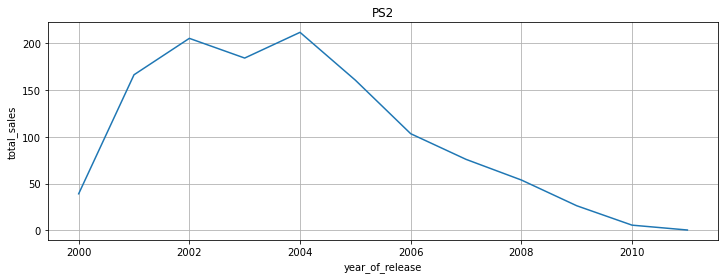

Срок поддержки платформы X360 в годах:     11


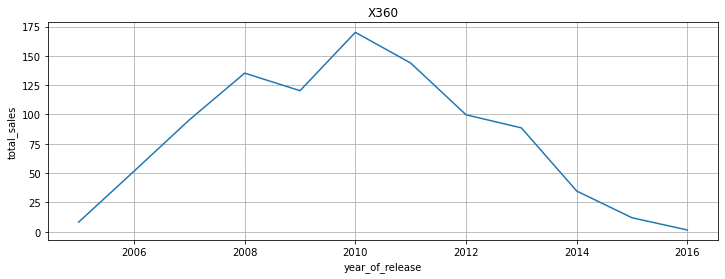

Срок поддержки платформы PS3 в годах:     10


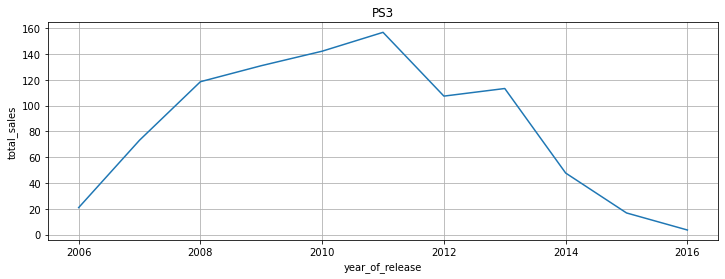

Срок поддержки платформы Wii в годах:     10


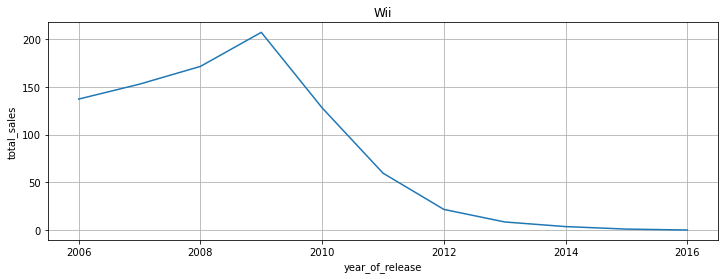

Срок поддержки платформы DS в годах:     9


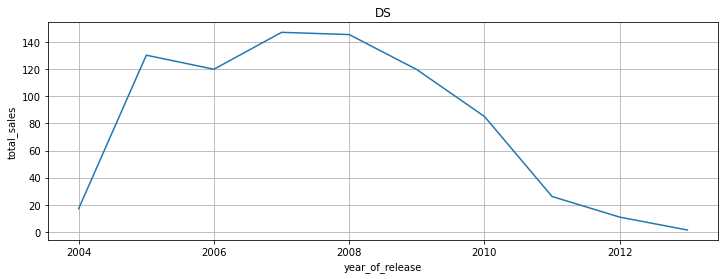

Срок поддержки платформы PS в годах:     9


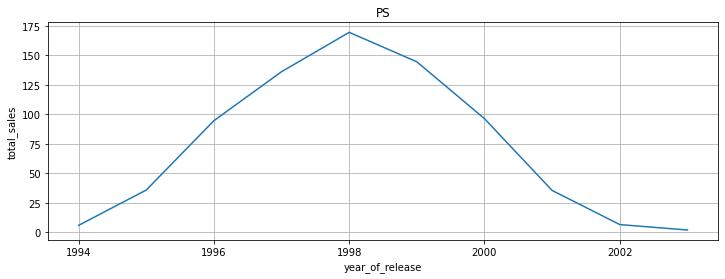

Срок поддержки платформы GBA в годах:     7


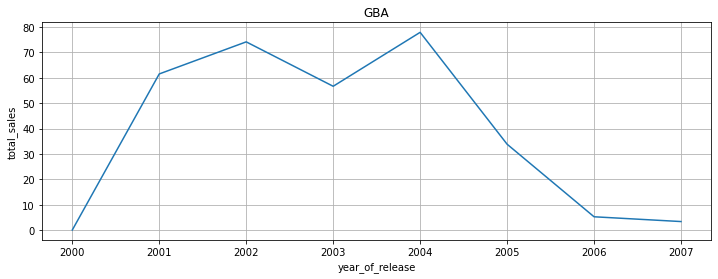

Срок поддержки платформы PS4 в годах:     3


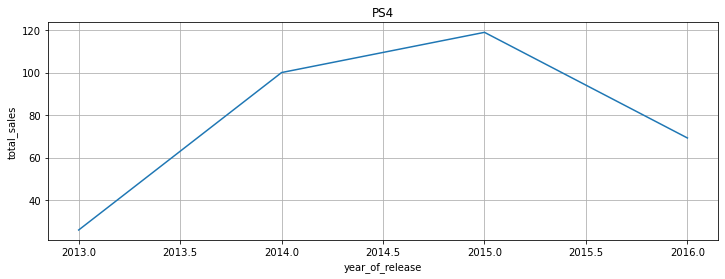

Срок поддержки платформы PSP в годах:     11


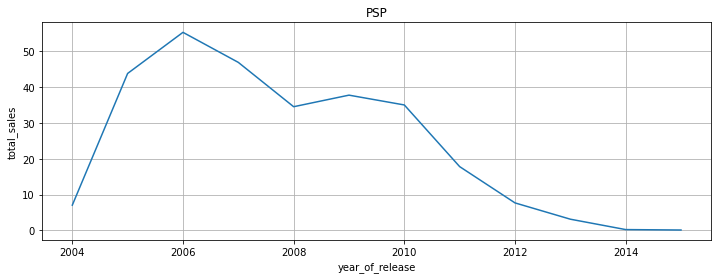

Срок поддержки платформы PC в годах:     31


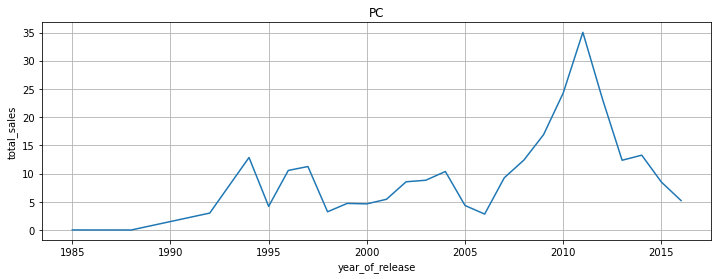

In [30]:
# построим графики срока поддержки платформы циклом
for i in platforms_top_10:
    print(f"Срок поддержки платформы {i} в годах: \
    {data[data['platform'] == i]['year_of_release'].max() - data[data['platform'] == i]['year_of_release'].min()}")
    plt.figure(figsize=(12,4))
    data[data['platform'] == i].groupby('year_of_release')['total_sales'].sum().plot()
    plt.title(i)
    plt.ylabel('total_sales')
    plt.grid()
    plt.show();

Платформы в основном живут около 9-10 лет. Новые платформы приходят ~ через каждые 6 лет, старые уходят ~ через 3 года после релиза новой платформы. Периоды максимальных продаж приходятся примерно на 4ый год с момента релиза.

####  Определим актуальный период.  

Для дальнейшего анализа, в качестве актуального на 2017г. возьмем период с 2014 по 2015 год, т.к. полные данные на 2016 год отсутствуют.

In [31]:
data['year_of_release'].value_counts()

2008    1427
2009    1426
2010    1255
2007    1197
2011    1136
2006    1006
2005     939
2002     829
2003     775
2004     762
2012     653
2015     606
2014     581
2013     544
2016     502
2001     482
1998     379
2000     350
1999     338
1997     289
1996     263
1995     219
1994     121
1993      60
1981      46
1992      43
1991      41
1982      36
1986      21
1989      17
1983      17
1990      16
1987      16
1988      15
1984      14
1985      13
1980       9
Name: year_of_release, dtype: Int64

In [32]:
data['year_of_release'].unique()

<IntegerArray>
[2006, 1985, 2008, 2009, 1996, 1989, 1984, 2005, 1999, 2007, 2010, 2013, 2004,
 1990, 1988, 2002, 2001, 2011, 1998, 2015, 2012, 2014, 1992, 1997, 1993, 1994,
 1982, 2016, 2003, 1986, 2000, <NA>, 1995, 1991, 1981, 1987, 1980, 1983]
Length: 38, dtype: Int64

In [33]:
data = data.loc[data['year_of_release'] != '<NA>']

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16443 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16443 non-null  object 
 1   platform         16443 non-null  object 
 2   year_of_release  16443 non-null  Int64  
 3   genre            16443 non-null  object 
 4   na_sales         16443 non-null  float64
 5   eu_sales         16443 non-null  float64
 6   jp_sales         16443 non-null  float64
 7   other_sales      16443 non-null  float64
 8   critic_score     16443 non-null  float64
 9   user_score       16443 non-null  float64
 10  rating           16443 non-null  object 
 11  total_sales      16443 non-null  float64
dtypes: Int64(1), float64(7), object(4)
memory usage: 1.6+ MB


In [35]:
data.year_of_release.unique()

<IntegerArray>
[2006, 1985, 2008, 2009, 1996, 1989, 1984, 2005, 1999, 2007, 2010, 2013, 2004,
 1990, 1988, 2002, 2001, 2011, 1998, 2015, 2012, 2014, 1992, 1997, 1993, 1994,
 1982, 2016, 2003, 1986, 2000, 1995, 1991, 1981, 1987, 1980, 1983]
Length: 37, dtype: Int64

In [36]:
#data = ((data['year_of_release'] >= 2014) & (data['year_of_release'] < 2015))

In [37]:
# отфильтруем данные по актуальному периоду
data = data.query('2014 <= year_of_release <= 2015', engine='python')

#### Выберем несколько потенциально прибыльных платформ.

''

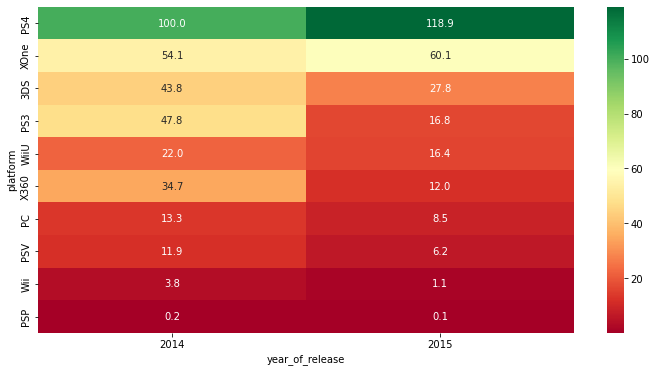

In [38]:
# выведем тепловую карту, отсортируем по 2015 году самые прибыльные платформы
plt.figure(figsize=(12,6))
sns.heatmap(data.pivot_table(index='platform', columns='year_of_release', values='total_sales', 
                aggfunc='sum').sort_values(2015, ascending=False), cmap='RdYlGn', annot=True, fmt='1.1f')
;

Растущая динамика прослеживается у PS4 и XOne, по продаже в 2015 году существенно лидирует PS4 - 118.9 млн. копий. Также платформа 3DS входит в топ-3 по количеству продаж - 27.8 млн. копий. По тепловой карте можно проследить нисходящую динамику продаж по остальным площадкам, в среднем она падает на ~ 35%, тем не менее платформы PS3, WiiU, X360, PC, PSV имеют свыше 6 млн. проданных копий в год.

#### Рассмотрим распределение по глобальным продажам игр в разбивке по платформам.

In [39]:
data.groupby('platform')['total_sales'].describe().T

platform,3DS,PC,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
count,166.000000,97.000000,181.000000,212.000000,13.000000,210.000000,10.000000,59.000000,98.000000,141.000000
mean,0.430964,0.224742,0.356796,1.032547,0.027692,0.086429,0.489000,0.650508,0.476531,0.810000
std,1.223959,0.391690,0.685857,1.935690,0.027735,0.162925,0.651928,1.275634,0.657035,1.220984
min,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000
25%,0.040000,0.030000,0.040000,0.090000,0.010000,0.020000,0.032500,0.055000,0.080000,0.110000
50%,0.090000,0.080000,0.120000,0.290000,0.020000,0.040000,0.165000,0.190000,0.230000,0.320000
75%,0.257500,0.260000,0.400000,0.972500,0.020000,0.100000,0.852500,0.605000,0.632500,0.910000
max,11.680000,3.050000,5.270000,14.630000,0.090000,1.960000,2.010000,7.090000,4.280000,7.390000


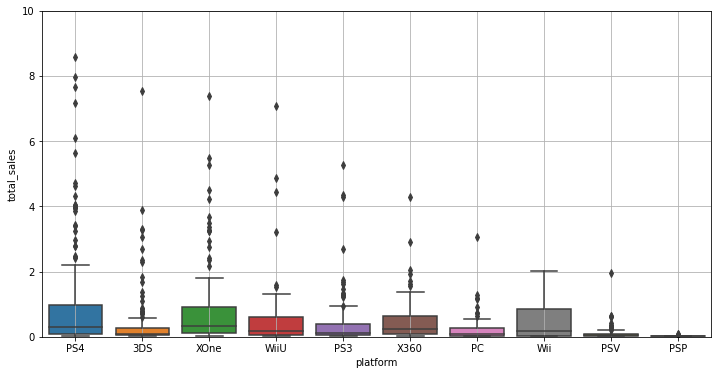

In [40]:
# построим диаграмму размаха по продажам игр на разных платформах
plt.figure(figsize=(12,6))
sns.boxplot(y=data['total_sales'], x=data['platform'])
plt.ylim(0,10)
plt.grid()

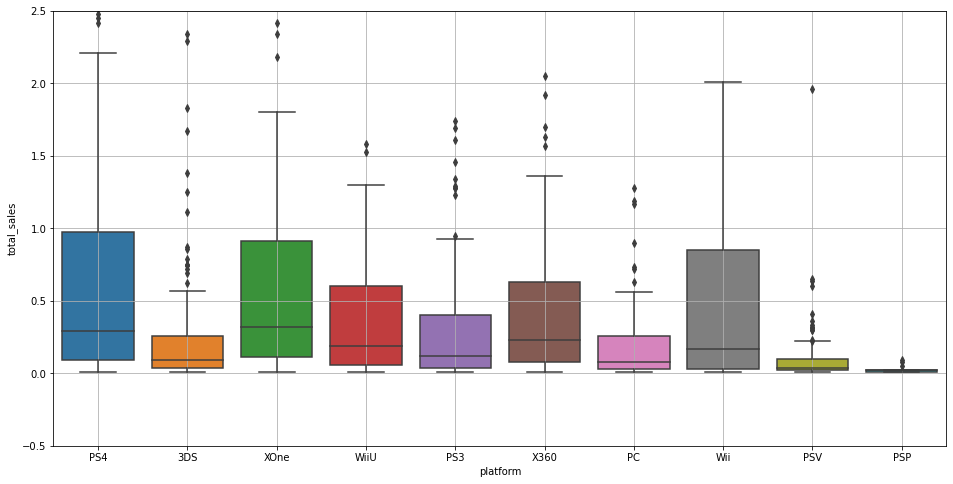

In [41]:
# построим диаграмму размаха по продажам игр на разных платформах в большем масштабе
plt.figure(figsize=(16,8))
sns.boxplot(y=data['total_sales'], x=data['platform'])
plt.ylim(-0.5,2.5)
plt.grid()

Практически по всем платформам имеются выбросы, то есть некоторые игры обеспечивают продажи превышающие средние значения. Выбросов практически нет на платформах PSP, PC, Wii и PSV. 

На платформах XOne и PS4 медиана практически на одном уровне - 0.32 и 0.29 соответственно; и выше, чем на остальных платформах. На трех платформах правый хвост сравнительно выше остальных, по ним можно выделить лидирующие по продажам платформы за выбранный период - XOne, PS4 и Wii. По количеству продаж чуть уступают платформы X360, WiiU, PS3.

#### Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. 

In [42]:
# присвоим переменной оценки критиков и пользователей без заглушек
data_filtered = data[(data['user_score'] != -1) & (data['critic_score'] != -1)]
data_filtered['user_score'].unique()

array([8.3, 4.3, 5.7, 6.5, 9.1, 6.1, 7.9, 5.4, 8.1, 6.4, 8.5, 6.2, 6.3,
       7.7, 9.2, 4.9, 7.6, 8.7, 6.7, 4.1, 8.2, 6.8, 5.5, 7.5, 4.4, 5.9,
       7.2, 6.9, 3.9, 8.6, 7. , 9. , 7.3, 5. , 7.4, 6. , 7.1, 8.8, 6.6,
       5.8, 8.9, 8. , 7.8, 8.4, 5.1, 5.2, 3.1, 9.3, 4. , 3.6, 3. , 3.7,
       5.6, 4.7, 5.3, 3.2, 4.5, 4.8, 3.3, 4.2, 1.5, 3.8, 2.5, 2.1, 3.4,
       4.6, 3.5, 1.9, 1.4, 2.4])

In [43]:
data_filtered['critic_score'].unique()

array([97., 82., 83., 87., 88., 76., 81., 86., 84., 80., 85., 92., 70.,
       72., 93., 75., 66., 89., 73., 74., 71., 79., 63., 61., 78., 64.,
       91., 77., 69., 96., 62., 90., 55., 95., 67., 65., 68., 50., 60.,
       56., 58., 46., 59., 57., 32., 54., 47., 53., 51., 39., 45., 19.,
       49., 43., 20., 36., 40., 44., 48., 42., 25., 35., 26.])

PS4
Коэффициент корреляции общих продаж с оценками пользователей:        -0.0
Коэффициент корреляции общих продаж с оценками критиков:        0.4


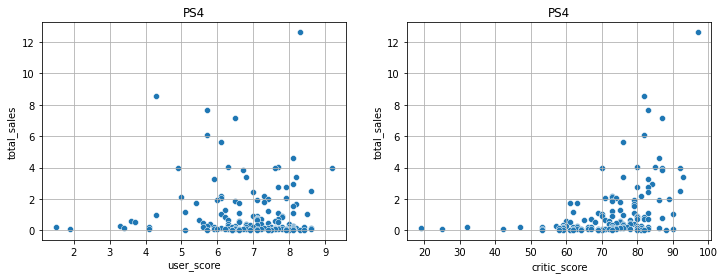

XOne
Коэффициент корреляции общих продаж с оценками пользователей:        -0.1
Коэффициент корреляции общих продаж с оценками критиков:        0.5


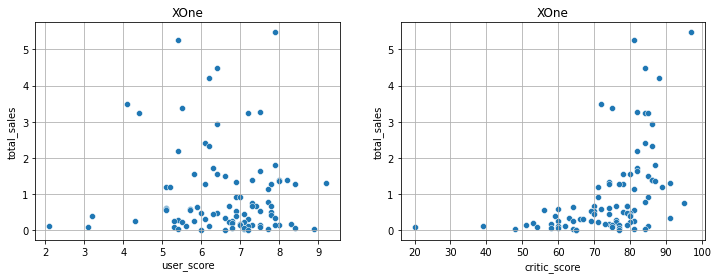

WiiU
Коэффициент корреляции общих продаж с оценками пользователей:        0.4
Коэффициент корреляции общих продаж с оценками критиков:        0.4


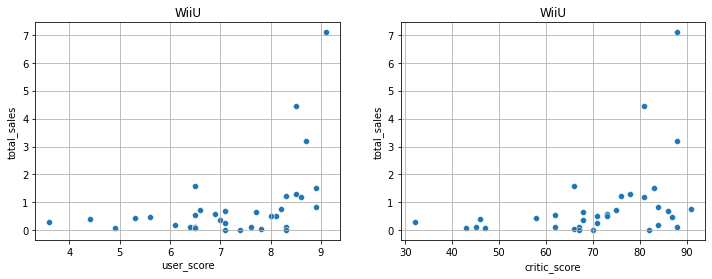

3DS
Коэффициент корреляции общих продаж с оценками пользователей:        0.3
Коэффициент корреляции общих продаж с оценками критиков:        0.3


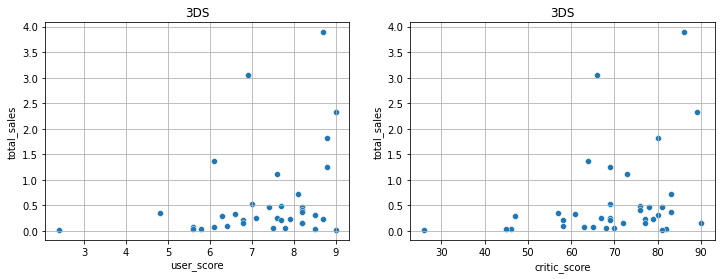

PC
Коэффициент корреляции общих продаж с оценками пользователей:        -0.2
Коэффициент корреляции общих продаж с оценками критиков:        0.2


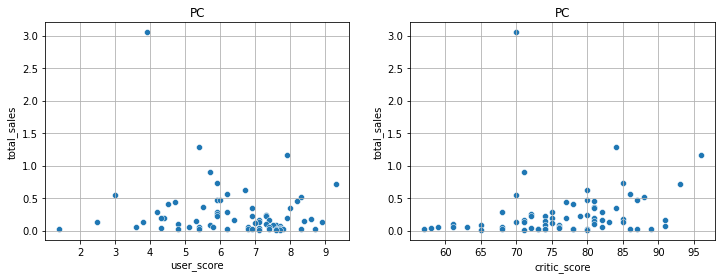

PS3
Коэффициент корреляции общих продаж с оценками пользователей:        0.2
Коэффициент корреляции общих продаж с оценками критиков:        0.4


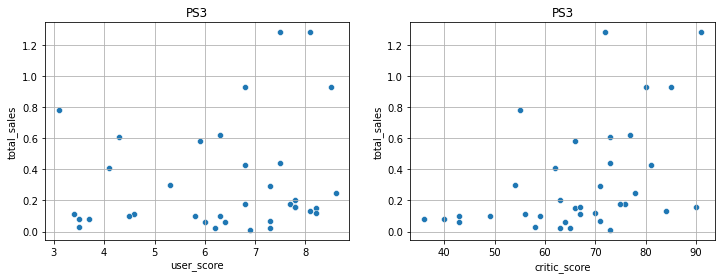

X360
Коэффициент корреляции общих продаж с оценками пользователей:        0.3
Коэффициент корреляции общих продаж с оценками критиков:        0.5


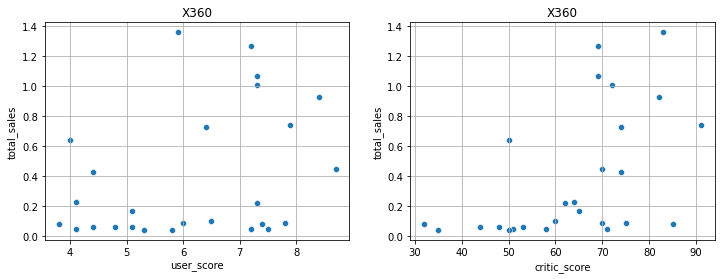

PSV
Коэффициент корреляции общих продаж с оценками пользователей:        0.0
Коэффициент корреляции общих продаж с оценками критиков:        0.1


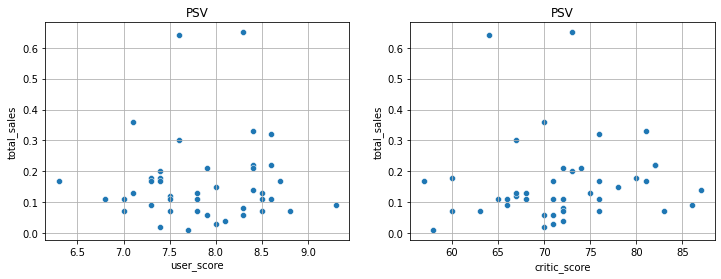

In [44]:
for i in data_filtered.groupby('platform')['total_sales'].sum().sort_values(ascending=False).index:
    print(i)
    print(f"Коэффициент корреляции общих продаж с оценками пользователей:\
        {data_filtered[data_filtered['platform'] == i]['user_score'].corr(data_filtered[data_filtered['platform'] == i]['total_sales']):.1f}")
    print(f"Коэффициент корреляции общих продаж с оценками критиков:\
        {data_filtered[data_filtered['platform'] == i]['critic_score'].corr(data_filtered[data_filtered['platform'] == i]['total_sales']):.1f}")
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    sns.scatterplot(data=data_filtered[data_filtered['platform'] == i], x = 'user_score', y='total_sales')
    plt.title(i)
    plt.grid()
    plt.subplot(1,2,2)
    sns.scatterplot(data=data_filtered[data_filtered['platform'] == i], x = 'critic_score', y='total_sales')
    plt.title(i)
    plt.grid()
    plt.show()

В рамках имеющихся данных затруднительно оценить повлияли ли оценки на раст продаж.
Корреляция указывает на то, что оценки критиков больше имеют связь с продажами, хотя очень слабую.

#### Соотнесем выводы с продажами игр на других платформах.

На других платформах можно сделать тот же вывод, коэффициент корреляции ориентировочно 0.2-0.4, что показывает слабую зависимость между продажами и оценками пользователей и критиков. Так же, значения более сгруппированные на графиках с оценками критиков. 
На платформе Wii самый высокий коэффициент корреляции - 0.6, по диаграмме можно было бы предположить, что продажи имеются только при оценках критиков свыше 70 баллов, но данных для анализа мало. 

#### Посмотрим на общее распределение игр по жанрам. 

In [45]:
data.groupby('genre')['total_sales'].describe().T

genre,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy
count,441.000000,129.000000,44.000000,81.000000,23.000000,13.000000,45.000000,167.000000,81.000000,26.000000,113.000000,24.000000
mean,0.383787,0.106434,0.539773,0.431481,0.646087,0.169231,0.549556,0.498563,1.638519,0.432308,0.760973,0.117917
std,0.916382,0.223665,1.366628,0.847930,0.843697,0.330768,1.158267,1.231749,2.335047,0.809090,1.260565,0.135742
min,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.020000,0.010000,0.010000,0.010000
25%,0.040000,0.020000,0.067500,0.030000,0.055000,0.020000,0.050000,0.060000,0.310000,0.040000,0.080000,0.027500
50%,0.110000,0.040000,0.130000,0.170000,0.250000,0.050000,0.170000,0.110000,0.680000,0.160000,0.360000,0.055000
75%,0.340000,0.090000,0.320000,0.410000,1.160000,0.110000,0.430000,0.465000,1.720000,0.360000,0.770000,0.212500
max,12.620000,1.660000,7.550000,5.270000,3.210000,1.190000,7.090000,11.680000,14.630000,3.050000,8.580000,0.520000


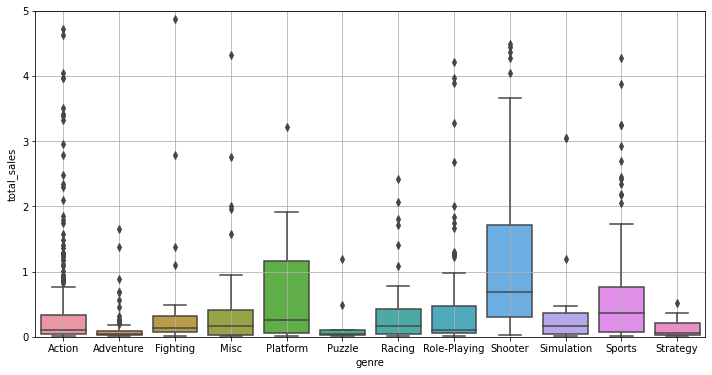

In [46]:
plt.figure(figsize=(12,6))
sns.boxplot(y=data['total_sales'], x=data['genre'].sort_values())
plt.ylim(0,5)
plt.grid()

''

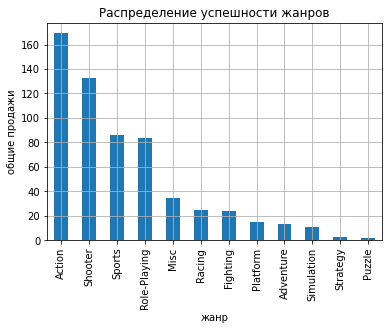

In [47]:
data.groupby('genre')['total_sales'].sum().sort_values(ascending=False).plot(kind='bar', grid=True)
plt.title('Распределение успешности жанров')
plt.xlabel('жанр')
plt.ylabel('общие продажи')
;

Самые высокие продажи (за период с 2014-2015гг.) в играх с следующими жанрами: Action, Shooter; далее по убыванию идут жанры Sports и Role-Playing. В играх с жанром Action, Shooter и Role-Playing большое количество выбросов, т.е. общих продаж превышающие средние значения. 
Самые низкие продажи в жанрах Strategy, Puzzle. 
Интересно как меняется распределение, по средним показателям лидирует жанр Shooter, но из-за бОльшего количества выпущенных игр и бОльшего количества выбросов, самым успешным жанром является Action.

**Выводы**

На основе исследовательского анализа данных, выявили следующие закономерности: 
- поддержка платформ в среднем составляет 9 лет, далее игры выпускаются для новых, более мощных платформ. После выпуска новых консолей, предыдущую версию поддерживают в течение 3 лет; 
- пик продаж игр прослеживается на 4 году жизни консоли, вероятно, новые консоли приобретают больше, когда выпускаемых игр становится больше и прекращается поддержка старых консолей;
- на рассматриваемый период популярностью пользуются следующие консоли: PS4, XOne, 3DS;
- несмотря на нисходящую динамику продаж, платформы: PS3, WiiU, X360, PC, PSV - имеют свыше 6 млн. проданных копий в год;
- большей популярностью пользуются жанры - Action и Shooter, и сравнимо меньше, но выше среднего - Sports, Role-Playing.

### Портрет пользователя каждого региона.

1. Самые популярные платформы (топ-5)
2. Самые популярные жанры (топ-5)
3. Влияет ли рейтинг ESRB на продажи в отдельном регионе?

#### Самые популярные платформы (топ-5)

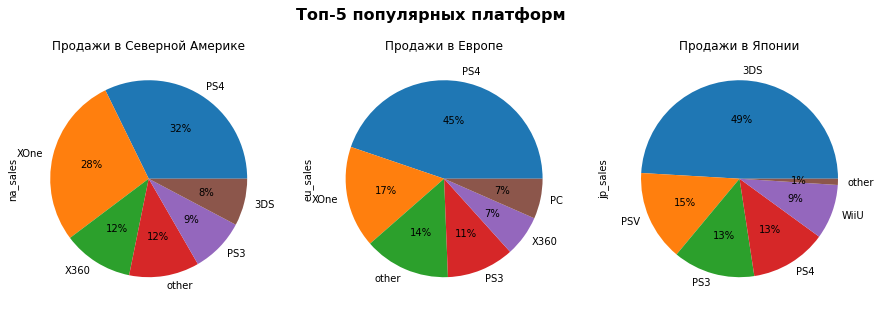

In [48]:
plt.figure(figsize=(15,5))
rus_title = ['Продажи в Северной Америке', 'Продажи в Европе', 'Продажи в Японии']
for i, region in enumerate(['na_sales', 'eu_sales', 'jp_sales']):
    data_temp = data.copy()
    top_platform = data_temp.groupby('platform')[region].sum().sort_values(ascending=False)[:5].index
    data_temp['top_platform'] = data_temp['platform'].apply(lambda x: x if x in top_platform else 'other')
    plt.subplot(1,3,i+1)
    data_temp.groupby(['top_platform'])[region].sum().sort_values(ascending=False).plot(kind='pie', autopct='%.0f%%', subplots=True, title=[rus_title[i]])


    plt.suptitle('Топ-5 популярных платформ', fontsize=16, fontweight='bold');


Самые популярные платформы в Северной Америке PS4 - 32%, XOne - 28%; в Европе PS4 - 45%, в Японии 3DS - 49%. 

In [49]:
# в графиках выбран актуальный период
data['year_of_release'].value_counts()

2015    606
2014    581
Name: year_of_release, dtype: Int64

#### Самые популярные жанры (топ-5)

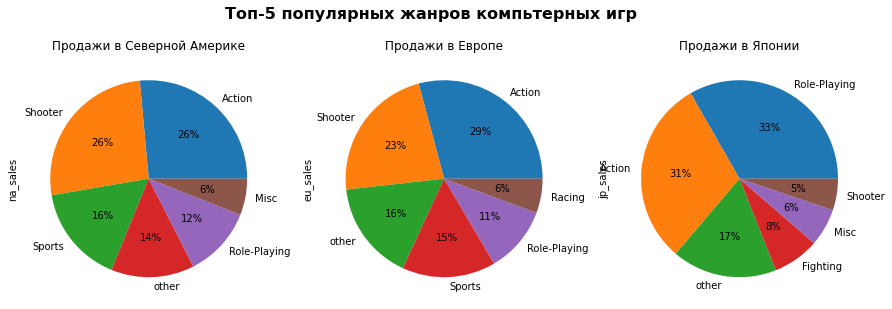

In [50]:
plt.figure(figsize=(15,5))
rus_title = ['Продажи в Северной Америке', 'Продажи в Европе', 'Продажи в Японии']
for i, region in enumerate(['na_sales', 'eu_sales', 'jp_sales']):
    data_temp = data.copy()
    top_genre = data_temp.groupby('genre')[region].sum().sort_values(ascending=False)[:5].index
    data_temp['top_genre'] = data_temp['genre'].apply(lambda x: x if x in top_genre else 'other')
    plt.subplot(1,3,i+1)
    data_temp.groupby(['top_genre'])[region].sum().sort_values(ascending=False).plot(kind='pie', autopct='%.0f%%', subplots=True, title=[rus_title[i]])
plt.suptitle('Топ-5 популярных жанров компьтерных игр', fontsize=16, fontweight='bold');


Самые популярные жанры в Северной Америке Action - 26%, Shooter - 26%; в Европе Action - 29%, Shooter - 263; в Японии Role-Playing - 33%, Action - 31%.

#### Влияние рейтинга ESRB на продажи в отдельном регионе.

In [51]:
region_rating = data.pivot_table(index='rating', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum', 
                                 margins=True)
region_rating

,eu_sales,jp_sales,na_sales
rating,,,
E,44.45,7.87,42.77
E10+,22.35,4.01,29.42
M,76.90,6.81,80.75
T,24.28,12.51,30.00
unknown,51.48,42.58,56.19
All,219.46,73.78,239.13


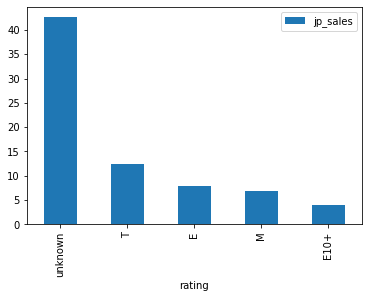

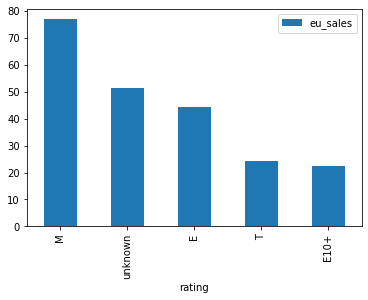

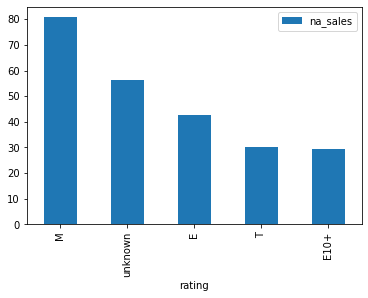

In [52]:
data.groupby(by='rating').agg({'jp_sales':'sum'}).sort_values(by='jp_sales', ascending=False).head(5).plot(kind='bar')
data.groupby(by='rating').agg({'eu_sales':'sum'}).sort_values(by='eu_sales', ascending=False).head(5).plot(kind='bar')
data.groupby(by='rating').agg({'na_sales':'sum'}).sort_values(by='na_sales', ascending=False).head(5).plot(kind='bar');

В Европе и Северной Америке распределение продаж совпадает: лидирует жанр категории М («Mature») — «Для взрослых», далее в порядке убывания E («Everyone») — «Для всех» , E10+ («Everyone 10 and older») — «Для всех от 10 лет и старше», T («Teen») — «Подросткам». Третье место в рейтинге занимает "unknown" - (пропущенные жанры в датасете). В Японии много пропущенных данных в жанре, далее в порядке убывания  E — «Для всех», T — «Подросткам», М — «Для взрослых», E10+ — «Для всех от 10 лет и старше».

**Выводы**

Предпочтения пользователей Европы и Северной Америки в большей степени схожи: пользователи из Европы в основном выбирают платформы PS3 и PS4, из Северной Америки X360 и PS3; игры в жанре Action и Shooter с рейтиногм от ESRB mature_17+. Предпочтения пользователей из Японии отличаются: в основном играют на японских приставках 3DS, выбирают для игр жанр Role-Playing и Action с рейтиногм от ESRB everyone и teen.

### Проверка гипотез.

1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
2. Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

####  Проверим первую гипотезу

Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

In [53]:
# группируем по платформам, выведем средние оценки и их количество

data_filtered.query("platform in ['XOne', 'PC']").groupby('platform')['user_score'].agg(['count', 'mean'])

,count,mean
platform,,
PC,70,6.370000
XOne,93,6.595699


Средние пользовательские рейтинги двух исследуемых платформ практически не различаются (разница в 0.01). Прооверим статистическую значимость.

- Н0: средние пользовательские рейтинги платформ Xbox One и PC равны;
- Н1: средние пользовательские рейтинги платформ Xbox One и PC не равны.

Гипотеза двусторонняя. Р-уровень примем соответствущим достоверному уровню статистической значимости (0,05).

In [54]:
pc = data_filtered.loc[(data_filtered['platform'] == 'PC') & (data_filtered['user_score']>0),'user_score']
xone = data_filtered.loc[(data_filtered['platform'] == 'XOne') & (data_filtered['user_score']>0),'user_score']

In [55]:
data_filtered[data_filtered['platform'] == 'PC']['year_of_release'].value_counts()

2014    37
2015    33
Name: year_of_release, dtype: Int64

In [56]:
data_filtered[data_filtered['platform'] == 'XOne']['year_of_release'].value_counts()

2015    50
2014    43
Name: year_of_release, dtype: Int64

In [57]:
results = st.ttest_ind(pc, xone)

alpha = 0.05

if results.pvalue < alpha:
    print(f'p-value = {results.pvalue}. Отвергаем нулевую гипотезу')
else:
    print(f'p-value = {results.pvalue}. Не получилось отвергнуть нулевую гипотезу')

p-value = 0.31823214868306726. Не получилось отвергнуть нулевую гипотезу


In [58]:
# Приведены два датасета: сумма покупок, совершённых за месяц посетителями ...

sample_1 = [3071, 3636, 3454, 3151, 2185, 3259, 1727, 2263, 2015,
2582, 4815, 633, 3186, 887, 2028, 3589, 2564, 1422, 1785,
3180, 1770, 2716, 2546, 1848, 4644, 3134, 475, 2686,
1838, 3352]
sample_2 = [1211, 1228, 2157, 3699, 600, 1898, 1688, 1420, 5048, 3007,
509, 3777, 5583, 3949, 121, 1674, 4300, 1338, 3066,
3562, 1010, 2311, 462, 863, 2021, 528, 1849, 255,
1740, 2596]
alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу
results = st.ttest_ind(
sample_1,
sample_2)
print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:

    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.1912450522572209
Не получилось отвергнуть нулевую гипотезу


#### Проверим вторую гипотезу

Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

In [59]:
# группируем по жанрам, выведем средние оценки и их количество
data_filtered.query("genre in ['Action', 'Sports']").groupby('genre')['user_score'].agg(['count', 'mean'])

,count,mean
genre,,
Action,158,6.902532
Sports,57,5.501754


Средние пользовательские оценки по жанрам различаются на 1,4 балл. Проверим статистическую значимость такого отклонения.

- Н0: средние пользовательские рейтинги жанров Action и Sports равны;
- Н1: средние пользовательские рейтинги жанров Action и Sports не равны.

Гипотеза двухсторонняя, проверяем гипотезу о равенстве средних двух генеральных совокупностей. Размеры выборок различаются существенно (зададим параметр equal_var=False). p-уровень примем соответствущим высокому уровню статистической значимости (0,01).

In [60]:
action = data_filtered[data_filtered['genre'] == 'Action']['user_score']
sports = data_filtered[data_filtered['genre'] == 'Sports']['user_score']

In [61]:
results2 = st.ttest_ind(action, sports)


alpha = 0.05

if results2.pvalue < alpha:
    print(f'p-value = {results2.pvalue}. Отвергаем нулевую гипотезу')
else:
    print(f'p-value = {results2.pvalue}. Не получилось отвергнуть нулевую гипотезу')

p-value = 1.508056868427328e-10. Отвергаем нулевую гипотезу


Значение p-value существенно меньше принятого уровня значимости. Нулевая гипотеза была бы отвергнута даже при установлении p-уровня значимости, равным 0,01, что интерпретируется как высокий уровень статистической значимости. Таким образом, различия в рейтинге пользователей жанров Action и Sports являются статистически значимыми.

### Общий вывод.

В ходе исследования данных установлен актуальный период 2014-2015 гг, анализ которого позволит сделать качественный прогноз. Основными регионами по продажам являются европейский и северо-американский. Выбраны три потенциально прибыльных платформы - PS4(118.9 млн. копий), XOne(60.1 млн. копий), 3DS(27.8 млн. копий). Однако не стоит оставлять без внимания платформы, которые сравнимо в меньшей степени, но приносят прибыль - PS3, WiiU, X360, PC, PSV - более 6 млн. копий в год. В Японии самой востребованной платформой является 3DS. Наиболее популярными жанрами являются Action и Shooter в Северной Америке и Европе, в Японии Action и Role-Playing. Предпочтения американских и европейских пользователей в основном совпадают, для японских пользователей она отличается. С учетом того, что популярность платформ достаточно быстро меняется, необходимо мониторить состояние рынка с целью своевременного реагирования на изменения пользовательских предпочтений.